In [951]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [952]:
data = pd.read_csv('mau_hist.csv')
data.head(2)

,gdp,gdp_growth,gpc,gpc_growth,pop,EPI,EPI_P
0,8802441342,5.727016,7100.861823,5.246497,1239630,73.85,73.85
1,9276625562,5.386963,7456.369246,5.006539,1244121,74.32,73.85


In [953]:
beta_epi = 0.9
beta_gdp = 0.9
K_EPI = 120

In [954]:
#economics = ['gdp','gdp_growth','gpc','gpc_growth']
economics = ['gdp','gdp_growth']
data = data[np.concatenate((economics,['EPI_P','EPI']))]
metadata = {idx:{'mean':float('nan'), 'std':float('nan')} for idx in data.columns}

In [955]:
for c in data.columns:
    metadata[c]['mean'] = np.mean(data[c])
    metadata[c]['std'] = np.std(data[c])

In [956]:
metadata

{'EPI': {'mean': 72.402, 'std': 1.1861433302936022},
 'EPI_P': {'mean': 72.702, 'std': 1.1339029940872343},
 'gdp': {'mean': 10591182875.8, 'std': 1129126209.9190583},
 'gdp_growth': {'mean': 4.075356001, 'std': 0.8073051302975812}}

In [957]:
for c in data.columns:
    scaled = (data[c]-metadata[c]['mean']) / (metadata[c]['std'])
    #scaled = data[c]
    data[c+'_scaled'] = scaled
data.head(2)

,gdp,gdp_growth,EPI_P,EPI,gdp_scaled,gdp_growth_scaled,EPI_P_scaled,EPI_scaled
0,8802441342,5.727016,73.85,73.85,-1.584182,2.045893,1.012432,1.220763
1,9276625562,5.386963,73.85,74.32,-1.164225,1.624673,1.012432,1.617005


In [958]:
for c in economics:
    sig = np.log(1+data[c])
    if c=='gdp':
        data[c+'_sigmoid'] = sig
    else:
         data[c+'_sigmoid'] = data[c]
data.head(2)

,gdp,gdp_growth,EPI_P,EPI,gdp_scaled,gdp_growth_scaled,EPI_P_scaled,EPI_scaled,gdp_sigmoid,gdp_growth_sigmoid
0,8802441342,5.727016,73.85,73.85,-1.584182,2.045893,1.012432,1.220763,22.898295,5.727016
1,9276625562,5.386963,73.85,74.32,-1.164225,1.624673,1.012432,1.617005,22.950764,5.386963


In [959]:
for c in economics:
    cross = data[c+'_scaled']*data['EPI_P_scaled']
    data[c+'_cross'] = cross

In [960]:
vars_to_use = ['gdp_sigmoid','gdp_growth','gdp_cross','gdp_growth_cross','EPI_P']
#vars_to_use = ['gdp_sigmoid','gdp_growth','gdp_cross','EPI_P']
#data_sigmoid = data[np.concatenate(([c+'_sigmoid' for c in economics],['EPI_P']))]
data_sigmoid = data[vars_to_use]
data_sigmoid.head(2)

,gdp_sigmoid,gdp_growth,gdp_cross,gdp_growth_cross,EPI_P
0,22.898295,5.727016,-1.603877,2.071328,73.85
1,22.950764,5.386963,-1.178699,1.644871,73.85


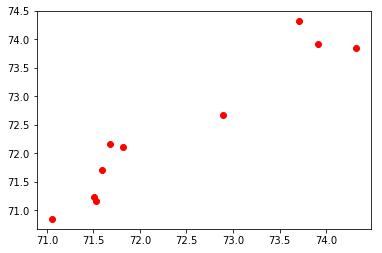

In [1015]:
from sklearn.linear_model import LinearRegression
lin_mod = LinearRegression()

lin_mod.fit(data_sigmoid, Y)
pred = lin_mod.predict(data_sigmoid)
plt.plot(pred,Y,'ro')
plt.show()

In [1016]:
lin_mod.score(data_sigmoid, Y)

0.91200955106899051

In [1022]:
from collections import Iterable
def gdp_growth_next(gdp_growth_last,last_noise, dev_speed=0):
    if not isinstance(gdp_growth_last,Iterable):
        gdp_growth_last=[gdp_growth_last]
    #return gdp_growth_last[-1] / (1+np.exp(-gdp_growth_last[-1])) + np.random.randn(),0
    #return 1/(1+np.exp(gdp_growth_last[-1])) + np.random.randn(), 0
    
    noise = np.random.randn()*1
    params = np.concatenate((gdp_growth_last, [noise]))
    coefs = [0.1964,0.2141,0.1927,0.1835,0.2061,0.1871]
    
    return np.sum([coefs[i]*params[i] for i in range(len(coefs))])+dev_speed, noise

In [1084]:
def predict_future(years_to=50,alpha=0,dev_speed=0):
    last = data.loc[data.index[-1],:]
    future = pd.DataFrame()
    future = future.append(last)

    last_noise = np.random.randn()
    last_gdp_growth_need = 5
    last_gdp_growth = list(data['gdp_growth'][:-last_gdp_growth_need])
    for idx in range(years_to):
        nextyear = pd.Series(index=data.columns)
        #nextyear['gdp_growth'] = gdp_growth_next(last['gdp_growth'])
        nx_growth, cur_noise = gdp_growth_next(last_gdp_growth, last_noise,dev_speed)
        #print(nx_growth)
        #print(nx_growth)
        nextyear['gdp_growth'] = nx_growth-alpha
    #    print(nextyear['gdp_growth'])

        nextyear['gdp'] = last['gdp'] * (100+last['gdp_growth']) / 100
    
        for c in metadata.keys():
            #print(np.mean(np.array(data.append(future)[c])))
            metadata[c]['mean'] = np.mean(np.array(data.append(future)[c]))
            metadata[c]['std'] = np.std(np.array(data.append(future)[c]))
    
        #print(metadata)
        for c in economics:
            scaled = (nextyear[c]-metadata[c]['mean']) / (metadata[c]['std'])
            #scaled = nextyear[c]
            nextyear[c+'_scaled'] = scaled
        
        for c in economics:
            if c=='gdp':
                sig = np.log(1+nextyear[c])
            else:
                sig = nextyear[c]
            nextyear[c+'_sigmoid'] = sig
        
        nextyear['EPI_P'] = last['EPI']
        nextyear['EPI_P_scaled'] = (nextyear['EPI_P'] - metadata['EPI']['mean']) / metadata['EPI']['std']
        #print(nextyear)
    
        for c in economics:
            cross = nextyear[c+'_scaled']*nextyear['EPI_P_scaled']
            nextyear[c+'_cross'] = cross
        
        
        #next_sigmoid = nextyear[np.concatenate(([c+'_sigmoid' for c in economics],['EPI_P']))]
        #print(next_sigmoid)
        next_sigmoid = nextyear[vars_to_use]
        next_sigmoid = np.array(next_sigmoid).reshape(1,-1)
        #print(next_sigmoid)
        EPI_pred = lin_mod.predict(next_sigmoid)
        nextyear['EPI'] = EPI_pred
        nextyear['gdp_growth'] = nextyear['gdp_growth'] + alpha
      #  print(nextyear['gdp_growth'])
        nextyear['gdp'] = last['gdp'] * (100+last['gdp_growth']) / 100

        last_noise = cur_noise
        last_gdp_growth.append(nextyear['gdp_growth'])
        last_gdp_growth = last_gdp_growth[1:]
    
        future = future.append(nextyear,ignore_index=True)
        last = future.loc[future.index[-1],:]
       # print('\n')
    return future

In [1104]:
linewidth=2

When economic is stable.

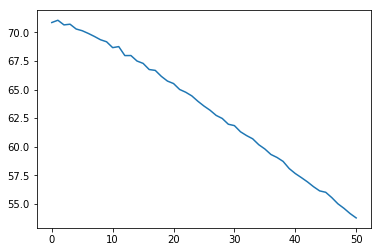

In [1105]:
future = predict_future(50,0,0.0)
plt.plot(future.EPI)
plt.show()

When economic develops rapidly. 

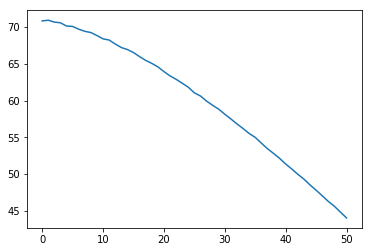

In [1107]:
future = predict_future(50,0,0.3)
plt.plot(future.EPI)
plt.show()

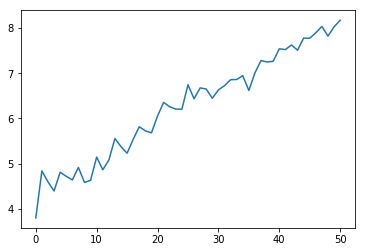

In [1109]:
plt.plot(future.gdp_growth)
plt.show()

In [1116]:
betas = np.arange(0.01,0.5,0.01)
epis = []
gdps_g = []
for b in betas:
    future=predict_future(50,0,b)
    epis.append(np.array(future.EPI)[-1])
    gdps_g.append(np.array(future.gdp_growth)[-1])

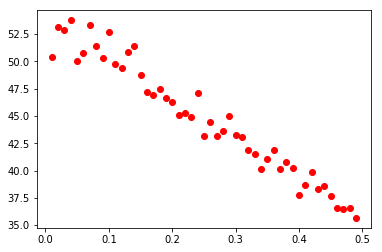

In [1117]:
plt.plot(betas, epis,'ro')
plt.show()

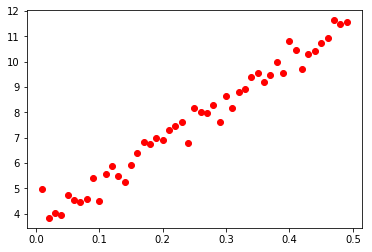

In [1118]:
plt.plot(betas, gdps_g,'ro')
plt.show()

beta=0.3, investment to environment

In [1168]:
def gettime(seconds):
    secs = seconds % 60
    mins = int((seconds % 3600) / 60)
    hours = int(seconds / 3600)
    return hours, mins, secs

gettime(3690)

(1, 1, 30)

In [1169]:
def gettime(seconds):
    secs = seconds % 60
    mins = int((seconds % 3600) / 60)
    hours = int(seconds / 3600)
    return hours, mins, secs


In [1171]:
import time
import sys
alphas = np.arange(1,20,0.5)
epis = []
innerstep = 10
totalstep = len(alphas)*innerstep
steplase = 0.0
stepcur = 0.0
step = 0
for i,a in enumerate(alphas):
    epi = 0.0
    for it in range(innerstep):
        step += 1
        stepstart=time.time()
        future=predict_future(50,a,0.3)
        epi += 0.1 * (np.array(future.EPI)[-1])
        stepused = time.time()-stepstart
        stepcur += stepused
        stepavg = stepcur / step
        timeneed = (totalstep - step)  * stepavg
        h, m, s = gettime(timeneed)
        sys.stdout.write("\r%.2f%%, estimated time to complete: %d:%d:%d" % (step/totalstep*100, h,m,s))
        sys.stdout.flush()
        steplase = stepused
    epis.append(epi)

4.21%, estimated time to complete: 0:3:36

KeyboardInterrupt: 

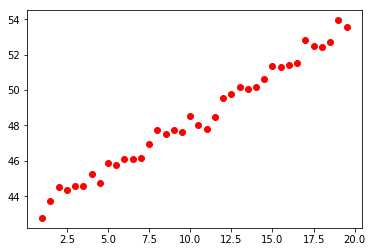

In [1139]:
plt.plot(alphas, epis,'ro')
plt.show()

In [1172]:
betas = np.arange(0.0,0.55,0.05)
alphas = np.arange(1,21,1)
tradeoff = pd.DataFrame(index=alphas, columns=betas)
innerstep = 10
totalstep = len(alphas)*innerstep*len(betas)
stepcur = 0.0
step = 0

for i,b in enumerate(betas):
    alpha = 0.0
    for a in alphas:
        tradeoff.loc[a,b] = 0.0
        for _ in range(innerstep):
            step+=1
            stepstart = time.time()
            future = predict_future(50,a, b)
            tradeoff.loc[a,b] += np.array(future.EPI)[-1] / innerstep
            stepcur += time.time() - stepstart
            stepavg = stepcur/step
            timeneed = (totalstep - step)  * stepavg
            h, m, s = gettime(timeneed)
            sys.stdout.write("\r%.2f%%, estimated time to complete: %d:%d:%d" % (step/totalstep*100, h,m,s))
            sys.stdout.flush()


100.00%, estimated time to complete: 0:0:00

In [1174]:
tradeoff.to_csv('tradeoff.csv')

In [1189]:
betas = [0.0,0.3,0.5]
years = np.arange(2017,2017+50,1).astype(int)
EPI_future = pd.DataFrame(index=years, columns=betas)

for b in betas:
    future = predict_future(50,0.0,b)
    EPI_array = np.array(future.EPI)[1:]
    EPI_future[b] = EPI_array

In [1192]:
EPI_future.to_csv('EPI_future.csv')